Ссылка на GitHub https://github.com/Iramira/Homework/blob/main/%D0%90%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_Buldakova_ipynb%22%22.ipynb
и ссылка на презентацию: https://docs.google.com/presentation/d/1SGICiAeaSFK2MObaGY5mPDXPEWVE7sCp/edit?usp=sharing&ouid=116907206108487001261&rtpof=true&sd=true



Аттестационная работа

Covid-19 forecasting COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. Возможность предвидеть путь пандемии имеет решающее значение. Это важно для того, чтобы определить, как бороться, и отследить его распространение.

Введение. Постановка целей и задач. Провести анализ данных о заболеваемости, предложить и настроить прогностическую модель, выполнить прогноз и сравнить результаты с новой статистикой (полученной после 5 апреля 2021 года)

Импортируем библиотеки, скачиваем realtime data по ссылке https://github.com/owid/covid-19-data/tree/master/public/data

In [89]:
!pip install nbconvert
import nbconvert
!pip install pmdarima
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima  
from pandas.plotting import lag_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [90]:
df = pd.read_csv('./owid-covid-data.csv', index_col='date', parse_dates = True, delimiter=",")

Знакомимся с данными с помощью функций head, count, info

In [91]:
df.head(5)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [92]:
df.count()

iso_code                                   137176
continent                                  128442
location                                   137176
total_cases                                129550
new_cases                                  129545
                                            ...  
human_development_index                    118554
excess_mortality_cumulative_absolute         4853
excess_mortality_cumulative                  4853
excess_mortality                             4853
excess_mortality_cumulative_per_million      4853
Length: 66, dtype: int64

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 137176 entries, 2020-02-24 to 2021-12-01
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    137176 non-null  object 
 1   continent                                   128442 non-null  object 
 2   location                                    137176 non-null  object 
 3   total_cases                                 129550 non-null  float64
 4   new_cases                                   129545 non-null  float64
 5   new_cases_smoothed                          128505 non-null  float64
 6   total_deaths                                118273 non-null  float64
 7   new_deaths                                  118469 non-null  float64
 8   new_deaths_smoothed                         128505 non-null  float64
 9   total_cases_per_million                     128886 non

Предобработка данных: нам даны 67 колонок данных по 160 странам, чтобы провести анализ данных и сделать прогноз ситуации по covid-19 - сделаем выборку данных по одной стране (Катар)

In [94]:
df = df[df.location=='Japan']

In [95]:
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,JPN,Asia,Japan,2.0,NaN,NaN,NaN,NaN,NaN,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-23,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-24,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-25,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-26,JPN,Asia,Japan,4.0,2.0,NaN,NaN,NaN,NaN,0.032,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,JPN,Asia,Japan,1726419.0,120.0,100.571,18354.0,1.0,1.571,13696.217,0.952,0.798,145.608,0.008,0.012,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39290.0,26543747.0,210.580,0.312,41075.0,0.326,0.002,408.4,people tested,NaN,NaN,NaN,NaN,NaN,136380.0,NaN,NaN,NaN,NaN,1082.0,27736.0,0.022,47.22,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2021-11-28,JPN,Asia,Japan,1726479.0,60.0,89.857,18354.0,0.0,1.571,13696.693,0.476,0.713,145.608,0.000,0.012,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23269.0,26567016.0,210.764,0.185,42145.0,0.334,0.002,469.0,people tested,196915615.0,99726235.0,97189380.0,NaN,NaN,126984.

Построим график

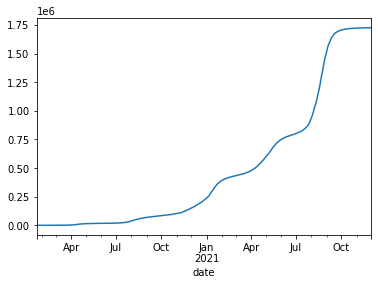

In [96]:
df[df.location=='Japan'].total_cases.plot()

In [97]:
df_lim = df[df.location=='Japan']
df_lim

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,JPN,Asia,Japan,2.0,NaN,NaN,NaN,NaN,NaN,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-23,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-24,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-25,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-26,JPN,Asia,Japan,4.0,2.0,NaN,NaN,NaN,NaN,0.032,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,JPN,Asia,Japan,1726419.0,120.0,100.571,18354.0,1.0,1.571,13696.217,0.952,0.798,145.608,0.008,0.012,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39290.0,26543747.0,210.580,0.312,41075.0,0.326,0.002,408.4,people tested,NaN,NaN,NaN,NaN,NaN,136380.0,NaN,NaN,NaN,NaN,1082.0,27736.0,0.022,47.22,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2021-11-28,JPN,Asia,Japan,1726479.0,60.0,89.857,18354.0,0.0,1.571,13696.693,0.476,0.713,145.608,0.000,0.012,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23269.0,26567016.0,210.764,0.185,42145.0,0.334,0.002,469.0,people tested,196915615.0,99726235.0,97189380.0,NaN,NaN,126984.

Удалим малоинформативные колонки данных, и оставим 5 наиболее важных для анализа и построения моделей прогнозирования:
- дата 
- общее количество случаев
- новые случаи заболеваний
- общее количество смертности
- новые случаи смертности

In [108]:
df_lim2 = df_lim[['total_cases',	'new_cases',	'total_deaths',	'new_deaths',"total_cases_per_million"]]
df_lim2

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million
date,,,,,
2020-01-22,2.0,NaN,NaN,NaN,0.016
2020-01-23,2.0,0.0,NaN,NaN,0.016
2020-01-24,2.0,0.0,NaN,NaN,0.016
2020-01-25,2.0,0.0,NaN,NaN,0.016
2020-01-26,4.0,2.0,NaN,NaN,0.032
...,...,...,...,...,...
2021-11-27,1726419.0,120.0,18354.0,1.0,13696.217
2021-11-28,1726479.0,60.0,18354.0,0.0,13696.693
2021-11-29,1726555.0,76.0,18355.0,1.0,13697.295


Выявим и устраним пропуски

In [109]:
df_lim2.isnull().sum()

total_cases                 0
new_cases                   1
total_deaths               22
new_deaths                 22
total_cases_per_million     0
dtype: int64

In [110]:
df1 = df_lim2.fillna(0)
df1

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million
date,,,,,
2020-01-22,2.0,0.0,0.0,0.0,0.016
2020-01-23,2.0,0.0,0.0,0.0,0.016
2020-01-24,2.0,0.0,0.0,0.0,0.016
2020-01-25,2.0,0.0,0.0,0.0,0.016
2020-01-26,4.0,2.0,0.0,0.0,0.032
...,...,...,...,...,...
2021-11-27,1726419.0,120.0,18354.0,1.0,13696.217
2021-11-28,1726479.0,60.0,18354.0,0.0,13696.693
2021-11-29,1726555.0,76.0,18355.0,1.0,13697.295


In [111]:
df1.duplicated()

date
2020-01-22    False
2020-01-23     True
2020-01-24     True
2020-01-25     True
2020-01-26    False
              ...  
2021-11-27    False
2021-11-28    False
2021-11-29    False
2021-11-30    False
2021-12-01    False
Length: 680, dtype: bool

Пропуски устранены, дубликаты не обнаружены.

EDA или разведочный анализ данных.

Определяем ключевым столбцом (index) дату стат. показателей в Df1, т.к. далее будем работать с временными рядами, а также меняем тип данных (time) в указанном столбце на подходящий нам для дальнейшей работы

In [112]:
df1['date']=df1['date'].astype('datetime64')
df1.index=df1.date
df1.info()
df1

KeyError: ignored

Выведем основную статистику

In [113]:
df1.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million
count,6.800000e+02,680.000000,680.000000,680.000000,680.000000
mean,4.901496e+05,2539.336765,6800.158824,26.997059,3888.508572
std,5.768463e+05,4334.067844,6659.578875,30.196899,4576.300211
min,2.000000e+00,0.000000,0.000000,0.000000,0.016000
25%,2.092650e+04,229.500000,982.000000,4.000000,166.016250
50%,2.198500e+05,982.500000,3254.000000,14.000000,1744.138000
75%,7.762382e+05,2765.250000,14151.750000,45.000000,6158.138500
max,1.726751e+06,25992.000000,18358.000000,216.000000,13698.850000


Стат.показатель 'mean' показывает, что среднее значение новых случаев заболеваний составляет 374, а количество новых смертельных случаев ежедневно составляет 0,9.

Стат.показатель 'max' показывает, что ежедневно выявляется до 2355 случаев заболеваний, а смертность составляет максимум 10.

Построим графики новых случаев заболеваний и новых смертельных случаев, посмотрим на их корреляцию.

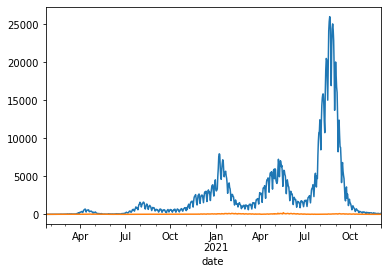

In [114]:
df1.new_cases.plot()
df1.new_deaths.plot()

In [115]:
df1.corr()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million
total_cases,1.000000,0.384692,0.954744,0.226896,1.000000
new_cases,0.384692,1.000000,0.426154,0.331027,0.384692
total_deaths,0.954744,0.426154,1.000000,0.323907,0.954744
new_deaths,0.226896,0.331027,0.323907,1.000000,0.226896
total_cases_per_million,1.000000,0.384692,0.954744,0.226896,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f705a7d7dd0>,
      dtype=object)

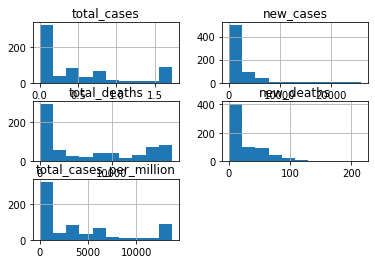

In [116]:
df1.hist()

на пересечении new_cases и new_deaths наблюдается корреляция

Text(0.5, 1.0, 'Новые случаи смертности')

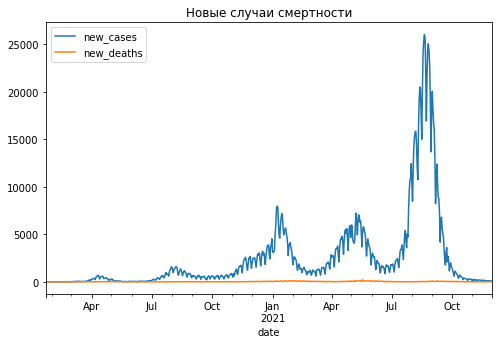

In [117]:
df1.new_cases.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи заболеваний") 
df1.new_deaths.plot(figsize=(8,5) , legend=True)
plt.title("Новые случаи смертности")

Для построения моделей и прогнозирования результатов используем: 
SARIMA и Экспоненциальную модель Holt-Winters' Model

Выполним ETS декомпозицию, используя аддитивную модель ('additive').

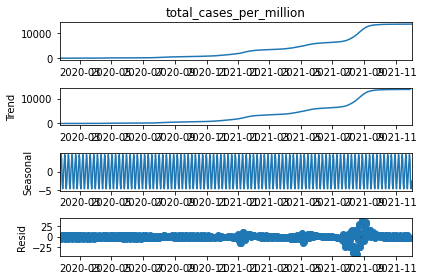

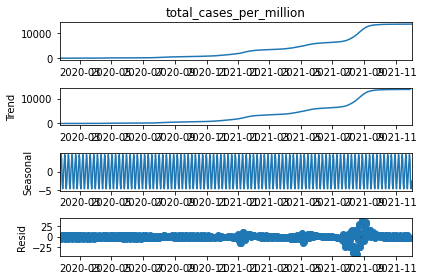

In [118]:
df2 = seasonal_decompose(df1['total_cases_per_million'], model='additive')
df2.plot()

Для определения значения факторов (p,d,q)(P,D,Q)s воспользуемся auto_arima:

In [119]:
auto_arima(df1['total_cases_per_million'], seasonal=True, m=2).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  680
Model:             SARIMAX(1, 2, 1)x(2, 0, [1, 2], 2)   Log Likelihood               -2111.045
Date:                                Wed, 22 Dec 2021   AIC                           4236.090
Time:                                        19:37:46   BIC                           4267.724
Sample:                                             0   HQIC                          4248.336
                                                - 680                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8499      0.017    -49.308      0.000      -0.884      -0.816
ma.L1          0.9684      0.012     82.677      0.000       0.945       0.991
ar.S.L2       -0.2865      0.019    -15.155      0.000      -0.324      -0.249
ar.S.L4       -0.8518      0.011    -74.739      0.000      -0.874      -0.830
ma.S.L2       -0.0341      0.022     -1.581      0.114      -0.076       0.008
ma.S.L4        0.8131      0.017     46.688      0.000       0.779       0.847
sigma2        29.5039      0.660     44.722      0.000      28.211      30.797
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):              5258.18
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):             118.24   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
df1.index.freq = 'D'
print(len(df1))
print(df1.head())

680
            total_cases  new_cases  ...  new_deaths  total_cases_per_million
date                                ...                                     
2020-01-22          2.0        0.0  ...         0.0                    0.016
2020-01-23          2.0        0.0  ...         0.0                    0.016
2020-01-24          2.0        0.0  ...         0.0                    0.016
2020-01-25          2.0        0.0  ...         0.0                    0.016
2020-01-26          4.0        2.0  ...         0.0                    0.032

[5 rows x 5 columns]


Установим 10 дней для тестирования. 

In [121]:
train = df1.iloc[:len(df1)-10]
test = df1.iloc[len(df1)-10:]

In [122]:
model = SARIMAX(train['total_cases_per_million'], order=(1, 0, 1), seasonal_order=(2, 1, [1,2], 2) )
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                total_cases_per_million   No. Observations:                  670
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 2)   Log Likelihood               -2211.374
Date:                                Wed, 22 Dec 2021   AIC                           4436.748
Time:                                        19:38:04   BIC                           4468.278
Sample:                                    01-22-2020   HQIC                          4448.962
                                         - 11-21-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.006    155.472      0.000       0.987       1.013
ma.L1          1.0000      3.348      0.299      0.765      -5.561       7.561
ar.S.L2        0.0255      0.021      1.217      0.223      -0.016       0.067
ar.S.L4        0.8760      0.021     41.825      0.000       0.835       0.917
ma.S.L2       -0.0009      3.357     -0.000      1.000      -6.581       6.579
ma.S.L4       -0.9991      3.340     -0.299      0.765      -7.546       5.548
sigma2        42.5769      0.158    270.261      0.000      42.268      42.886
===================================================================================
Ljung-Box (L1) (Q):                  27.00   Jarque-Bera (JB):              7503.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             168.17   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.61e+19. Standard errors may be unstable.
"""

Получили прогнозируемые значения

In [123]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 0)x(2, 0, [0], 12)')

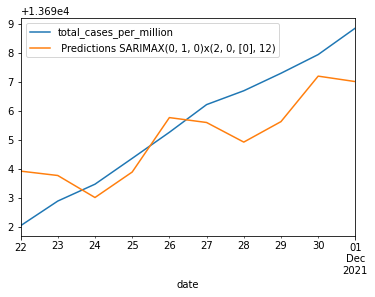

In [124]:
test['total_cases_per_million'].plot(legend=True)
predictions.plot(legend=True)

In [125]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12)')

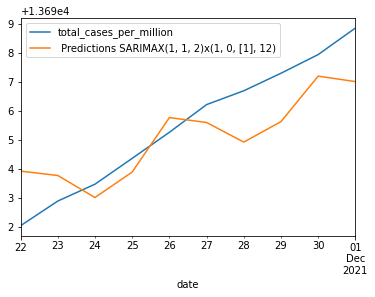

In [126]:
test['total_cases_per_million'].plot(legend=True)
predictions.plot(legend=True)

выводим первые 5 значений для test, predictions и train

In [127]:
predictions.head()

2021-11-22    13693.929711
2021-11-23    13693.779101
2021-11-24    13693.021982
2021-11-25    13693.897653
2021-11-26    13695.770183
Freq: D, Name:  Predictions SARIMAX(1, 1, 2)x(1, 0, [1], 12), dtype: float64

In [128]:
test['total_cases_per_million'].head()

date
2021-11-22    13692.052
2021-11-23    13692.900
2021-11-24    13693.480
2021-11-25    13694.368
2021-11-26    13695.265
Freq: D, Name: total_cases_per_million, dtype: float64

In [129]:
train['total_cases_per_million'].head()

date
2020-01-22    0.016
2020-01-23    0.016
2020-01-24    0.016
2020-01-25    0.016
2020-01-26    0.032
Freq: D, Name: total_cases_per_million, dtype: float64

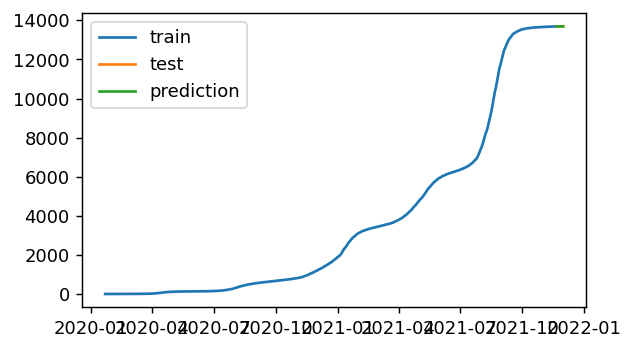

In [130]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['total_cases_per_million'], label='train')
plt.plot(test['total_cases_per_million'], label='test')
plt.plot(predictions, label='prediction')
plt.legend()
plt.show()

Оценим качество модели SARIMA с помощью MAE, MAPE и MSE 

In [131]:
print('Расчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['total_cases_per_million'], predictions))
print('MAPE:', mean_absolute_percentage_error(test['total_cases_per_million'], predictions))
print('MSE:', mean_squared_error(test['total_cases_per_million'], predictions))

Расчет точности полученного прогноза
MAE: 1.081723476281877
MAPE: 7.898217187942637e-05
MSE: 1.5187342999467874


В целом, модель прогнозирования на 10 дней подтверждает, что волна новых заболеваний и случаев смертности ещё не закончилась.

Экспоненциальное сглаживание - модель Хольта-Винтера (Holt-Winters' Model)

In [132]:
start=len(train)
end=len(train)+len(test)-1
predictions_hw = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1, 0, 0)x(0, 1, [1,2], 2) ')
predictions_hw

2021-11-22    13693.929711
2021-11-23    13693.779101
2021-11-24    13693.021982
2021-11-25    13693.897653
2021-11-26    13695.770183
2021-11-27    13695.601930
2021-11-28    13694.927751
2021-11-29    13695.631892
2021-11-30    13697.196305
2021-12-01    13697.008246
Freq: D, Name: SARIMA(1, 0, 0)x(0, 1, [1,2], 2) , dtype: float64

In [133]:
model_hw = ExponentialSmoothing(train['total_cases_per_million'], trend='add',seasonal='add',seasonal_periods=2).fit()

In [134]:
predictions_hw = model_hw.predict(start=start, end=end)

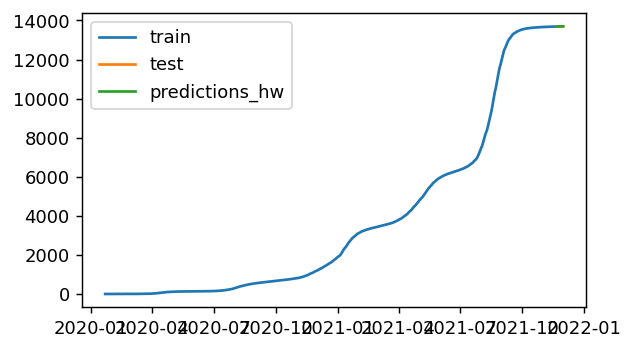

In [135]:
plt.figure(figsize=(5,3), dpi=130)
plt.plot(train['total_cases_per_million'], label='train')
plt.plot(test['total_cases_per_million'], label='test')
plt.plot(predictions_hw, label='predictions_hw')
plt.legend()
plt.show()

Оценим качество модели Хольта-Винтера с помощью MAE, MAPE и MSE 

In [136]:
print('Рассчет точности полученного прогноза')
print('MAE:', mean_absolute_error(test['total_cases_per_million'], predictions_hw))
print('MAPE:', mean_absolute_percentage_error(test['total_cases_per_million'], predictions_hw))
print('MSE:', mean_squared_error(test['total_cases_per_million'], predictions_hw))

Рассчет точности полученного прогноза
MAE: 1.9870661767163256
MAPE: 0.0001450789564253326
MSE: 4.74281633330753


Модель Хольта-Винтера показала меньшую погрешность прогнозирования, чем модель SARIMAX. Значит, в данном случае надо опираться на данные модели  Хольта-Винтера.

Попробуем еще проанализировать данные другим способом

In [137]:
df = pd.read_csv('./owid-covid-data.csv', index_col='date', parse_dates = True)
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,ZWE,Africa,Zimbabwe,133836.0,0.0,31.571,4704.0,0.0,0.714,8867.909,0.000,2.092,311.685,0.000,0.047,1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4152.0,1449073.0,96.015,0.275,2788.0,0.185,0.011,88.3,tests performed,6560442.0,3765392.0,2795050.0,NaN,16111.0,23490.0,43.47,24.95,18.52,NaN,1556.0,16225.0,0.108,47.22,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
2021-11-28,ZWE,Africa,Zimbabwe,133951.0,115.0,43.429,4705.0,1.0,0.857,8875.529,7.620,2.878,311.751,0.066,0.057,1.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1044.0,1450117.0,96.084,0.069,2764.0,0.183,0.016,63.6,tests performed,6568694.0,377088

In [138]:
df.location.value_counts().index

Index(['Peru', 'Mexico', 'Argentina', 'Thailand', 'Taiwan', 'South Korea',
       'China', 'World', 'Lower middle income', 'Asia',
       ...
       'Tuvalu', 'Cook Islands', 'Nauru', 'Bonaire Sint Eustatius and Saba',
       'Tokelau', 'Palau', 'Saint Helena', 'Pitcairn', 'Falkland Islands',
       'Niue'],
      dtype='object', length=237)

In [139]:
df = df[df.location=='Japan']

In [140]:
df

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,JPN,Asia,Japan,2.0,NaN,NaN,NaN,NaN,NaN,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-23,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-24,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-25,JPN,Asia,Japan,2.0,0.0,NaN,NaN,NaN,NaN,0.016,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2020-01-26,JPN,Asia,Japan,4.0,2.0,NaN,NaN,NaN,NaN,0.032,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27,JPN,Asia,Japan,1726419.0,120.0,100.571,18354.0,1.0,1.571,13696.217,0.952,0.798,145.608,0.008,0.012,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39290.0,26543747.0,210.580,0.312,41075.0,0.326,0.002,408.4,people tested,NaN,NaN,NaN,NaN,NaN,136380.0,NaN,NaN,NaN,NaN,1082.0,27736.0,0.022,47.22,126050796.0,347.778,48.2,27.049,18.493,39002.223,NaN,79.37,5.72,11.2,33.7,NaN,13.05,84.63,0.919,NaN,NaN,NaN,NaN
2021-11-28,JPN,Asia,Japan,1726479.0,60.0,89.857,18354.0,0.0,1.571,13696.693,0.476,0.713,145.608,0.000,0.012,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23269.0,26567016.0,210.764,0.185,42145.0,0.334,0.002,469.0,people tested,196915615.0,99726235.0,97189380.0,NaN,NaN,126984.

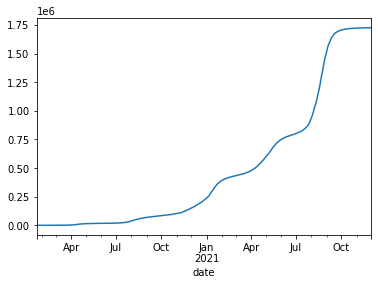

In [141]:
df[df.location=='Japan'].total_cases.plot()

In [142]:
df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,6.800000e+02,679.000000,674.000000,658.000000,658.000000,674.000000,680.000000,679.000000,674.000000,658.000000,658.000000,674.000000,646.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,662.000000,6.620000e+02,662.000000,662.000000,658.000000,658.000000,658.000000,658.000000,2.260000e+02,2.260000e+02,2.120000e+02,0.0,1.920000e+02,2.860000e+02,226.00000,226.000000,212.000000,0.0,286.000000,2.860000e+02,286.000000,678.000000,680.0,6.800000e+02,6.800000e+02,6.800000e+02,6.800000e+02,6.800000e+02,0.0,6.800000e+02,6.800000e+02,6.800000e+02,6.800000e+02,0.0,6.800000e+02,6.800000e+02,6.800000e+02,21.000000,21.000000,21.000000,21.000000
mean,4.901496e+05,2543.076583,2561.531822,7027.519757,27.899696,27.232316,3888.508572,20.175016,20.321430,55.751492,0.221386,0.216033,1.034211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40278.613293,8.278407e+06,65.675159,0.319542,40324.095745,0.319888,0.056217,42.414134,7.019115e+07,3.933588e+07,3.289288e+07,NaN,7.907232e+05,6.882271e+05,55.68469,31.206504,26.095142,NaN,5459.905594,3.486522e+05,0.276605,41.608289,126050796.0,3.477780e+02,4.820000e+01,2.704900e+01,1.849300e+01,3.900222e+04,NaN,7.937000e+01,5.720000e+00,1.120000e+01,3.370000e+01,NaN,1.305000e+01,8.463000e+01,9.190000e-01,-22027.561905,-2.514762,0.135238,-174.751470
std,5.768463e+05,4336.164738,4256.746843,6650.929169,30.284731,28.240903,4576.300211,34.400147,33.770072,52.763881,0.240242,0.224022,0.341377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37359.211177,8.609784e+06,68.304084,0.296379,32100.225449,0.254652,0.043459,65.365754,7.051952e+07,3.667434e+07,3.421511e+07,NaN,7.302009e+05,5.253487e+05,55.94538,29.094633,27.143968,NaN,4167.727191,2.862957e+05,0.227125,10.282075,0.0,2.730493e-12,5.119674e-13,2.844263e-13,2.524283e-13,2.621273e-10,NaN,8.248363e-13,8.177256e-14,1.244365e-13,4.124181e-13,NaN,6.044059e-14,9.386068e-13,8.332802e-15,9606.499235,1.585606,3.732471,76.211333
min,2.000000e+00,0.000000,0.571000,1.000000,0.000000,0.000000,0.016000,0.000000,0.005000,0.008000,0.000000,0.000000,0.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000e+00,0.000000,0.000000,9.000000,0.000000,0.002000,4.800000,1.250000e+02,1.250000e+02,3.500000e+01,NaN,4.860000e+02,4.860000e+02,0.00000,0.000000,0.000000,NaN,4.000000,4.860000e+02,0.000000,2.780000,126050796.0,3.477780e+02,4.820000e+01,2.704900e+01,1.849300e+01,3.900222e+04,NaN,7.937000e+01,5.720000e+00,1.120000e+01,3.370000e+01,NaN,1.305000e+01,8.463000e+01,9.190000e-01,-31959.400000,-5.570000,-5.570000,-253.543817
25%,2.092650e+04,230.000000,257.357000,998.250000,5.000000,5.143000,166.016250,1.825000,2.042000,7.919000,0.040000,0.041000,0.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8034.500

Посмотрим содержание столбцов

In [143]:
df.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vac

Возьмем для отображения следующие параметры: "общее количество случаев", "новые случаи", "общее количество смертей", "новое количество смертей","общее количество случаев заболевания на один миллион", "новые случаи заболевания на один миллион", "общее количество смертей на один миллион". "новое количество смертей на один миллион"

In [144]:
df1 = df[['total_cases', 'new_cases',
       'total_deaths', 'new_deaths',
       'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million',]]

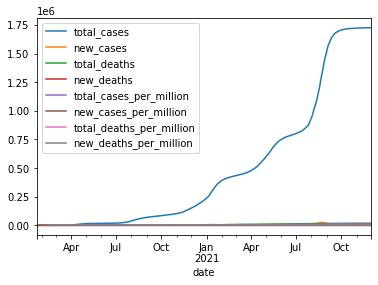

In [145]:
df1.plot()

Возьмем для отображения следующие параметры:  "новые случаи", "общее количество смертей", "новое количество смертей","общее количество случаев заболевания на один миллион", "новые случаи заболевания на один миллион", "общее количество смертей на один миллион". "новое количество смертей на один миллион"

In [146]:
df2 = df[['new_cases',
       'total_deaths', 'new_deaths',
       'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million',]]

In [147]:
df2

,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million
date,,,,,,,
2020-01-22,NaN,NaN,NaN,0.016,NaN,NaN,NaN
2020-01-23,0.0,NaN,NaN,0.016,0.000,NaN,NaN
2020-01-24,0.0,NaN,NaN,0.016,0.000,NaN,NaN
2020-01-25,0.0,NaN,NaN,0.016,0.000,NaN,NaN
2020-01-26,2.0,NaN,NaN,0.032,0.016,NaN,NaN
...,...,...,...,...,...,...,...
2021-11-27,120.0,18354.0,1.0,13696.217,0.952,145.608,0.008
2021-11-28,60.0,18354.0,0.0,13696.693,0.476,145.608,0.000
2021-11-29,76.0,18355.0,1.0,13697.295,0.603,145.616,0.008


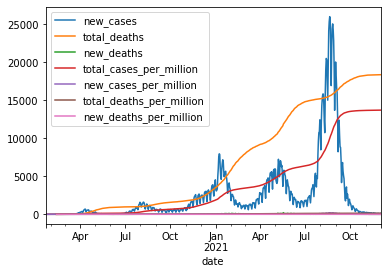

In [148]:
df2.plot()

Спрогнозируем общее количество заболевших на один миллион человек


In [149]:
df3 = df[['total_cases_per_million']]

In [150]:
df3

,total_cases_per_million
date,
2020-01-22,0.016
2020-01-23,0.016
2020-01-24,0.016
2020-01-25,0.016
2020-01-26,0.032
...,...
2021-11-27,13696.217
2021-11-28,13696.693
2021-11-29,13697.295


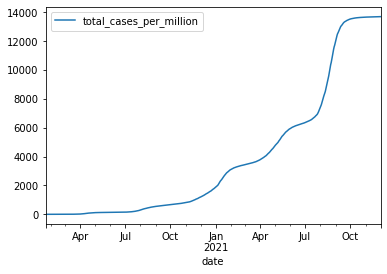

In [151]:
df3.plot()

Количество заболевших возрастает

Гипотеза: общее количество случаев заболевших на миллион человек после 5 апреля 2021 года: с 5 апреля по 5 мая

In [152]:
df4 = df3[:'2021-04-05']

Собираем исторические данные

In [153]:
df4

,total_cases_per_million
date,
2020-01-22,0.016
2020-01-23,0.016
2020-01-24,0.016
2020-01-25,0.016
2020-01-26,0.032
...,...
2021-04-01,3789.671
2021-04-02,3811.519
2021-04-03,3833.510


Проводим предварительный разведочный анализ данных

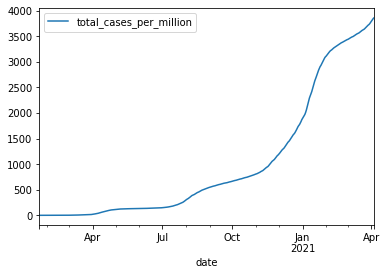

In [154]:
df4.plot()

Определяем наличие тренда и сезонности

Выполним декомпозицию

In [155]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [156]:
r = seasonal_decompose(df4['total_cases_per_million'],model='additive')

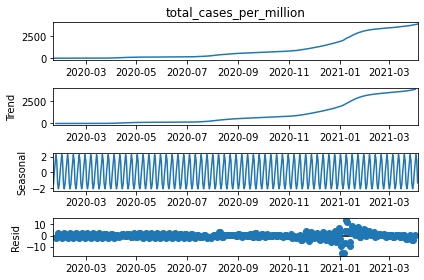

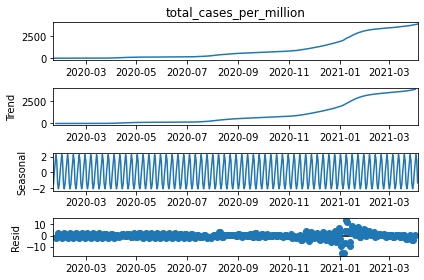

In [157]:
r.plot()

Тренд возрастает, сезонная компонента плюс/минус 5, диапазон от 0 до 60000, сезонные колебания выделяются в районе 5 дней, остатки колеблются в районе от - 100 до 100 дней

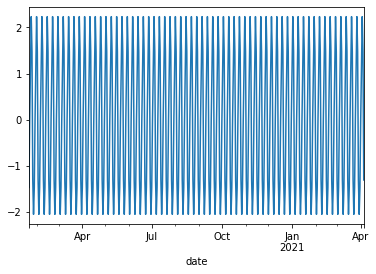

In [158]:
r.seasonal.plot()

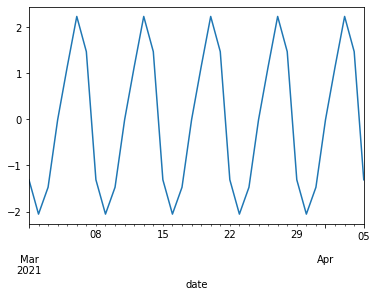

In [159]:
r.seasonal['2021-03-01':'2021-04-30'].plot()

Наблюдаем недельные колебания от плюс 8 до минус 6 человек

Остатки

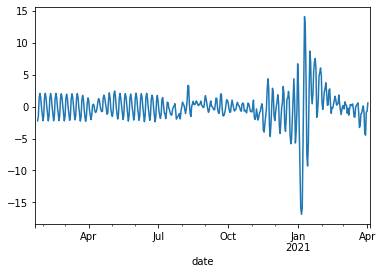

In [160]:
r.resid.plot()

Остатки (плюс 150, минус 100) превышают сезонность. Сезонность хоть и выделена, но меньше, чем случайные колебания

Выбираем модель ARIMA

In [161]:
auto_arima(df4['total_cases_per_million'],seasonal=True,d=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  440
Model:               SARIMAX(5, 7, 0)   Log Likelihood               -1470.388
Date:                Wed, 22 Dec 2021   AIC                           2952.777
Time:                        19:42:02   BIC                           2977.201
Sample:                             0   HQIC                          2962.419
                                - 440                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.2780      0.032    -70.640      0.000      -2.341      -2.215
ar.L2         -2.8269      0.074    -38.144      0.000      -2.972      -2.682
ar.L3         -2.3354      0.095    -24.526      0.000      -2.522      -2.149
ar.L4         -1.1750      0.074    -15.873      0.000      -1.320      -1.030
ar.L5         -0.1982      0.032     -6.223      0.000      -0.261      -0.136
sigma2        51.3856      1.475     34.844      0.000      48.495      54.276
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):              1761.51
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):              75.47   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Разбиваем выборку на обучающую и тестовую

In [162]:
train = df4[:'2021-03-05']
test = df4['2021-03-06':]

In [163]:
train

,total_cases_per_million
date,
2020-01-22,0.016
2020-01-23,0.016
2020-01-24,0.016
2020-01-25,0.016
2020-01-26,0.032
...,...
2021-03-01,3437.773
2021-03-02,3444.818
2021-03-03,3454.679


In [164]:
test

,total_cases_per_million
date,
2021-03-06,3481.335
2021-03-07,3489.831
2021-03-08,3494.591
2021-03-09,3503.532
2021-03-10,3513.948
2021-03-11,3524.397
2021-03-12,3534.480
2021-03-13,3544.944
2021-03-14,3552.774


In [165]:
model = SARIMAX(train['total_cases_per_million'],order=(5, 7, 0),seasonal_order=(1, 0, 1, 7))
results = model.fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             total_cases_per_million   No. Observations:                  409
Model:             SARIMAX(5, 7, 0)x(1, 0, [1], 7)   Log Likelihood               -1270.935
Date:                             Wed, 22 Dec 2021   AIC                           2557.870
Time:                                     19:42:19   BIC                           2589.842
Sample:                                 01-22-2020   HQIC                          2570.529
                                      - 03-05-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3619      0.028    -83.299      0.000      -2.417      -2.306
ar.L2         -2.9454      0.067    -43.822      0.000      -3.077      -2.814
ar.L3         -2.5087      0.090    -27.779      0.000      -2.686      -2.332
ar.L4         -1.4759      0.079    -18.751      0.000      -1.630      -1.322
ar.L5         -0.4696      0.037    -12.538      0.000      -0.543      -0.396
ar.S.L7        0.9548      0.016     60.367      0.000       0.924       0.986
ma.S.L7       -0.6702      0.042    -16.037      0.000      -0.752      -0.588
sigma2        31.6524      1.273     24.867      0.000      29.158      34.147
===================================================================================
Ljung-Box (L1) (Q):                  13.38   Jarque-Bera (JB):              1233.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              41.95   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Делаем прогноз

In [166]:
predictions = results.predict(start='2021-03-06', end='2021-04-05', dynamic=False, typ='levels').rename('Predictions')

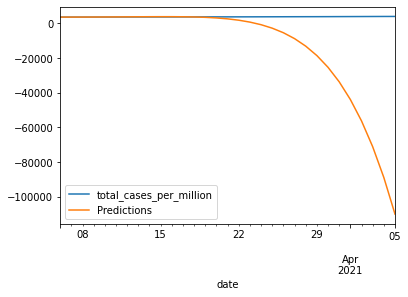

In [167]:
test['total_cases_per_million'].plot(legend=True)
predictions.plot(legend=True)

Прогноз на неделю хороший, затем ухудшается

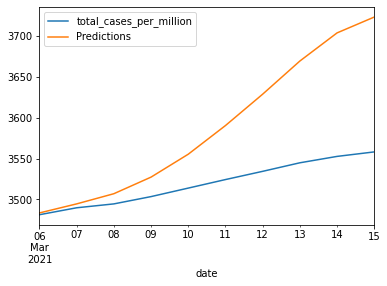

In [168]:
test['total_cases_per_million']['2021-03-06':'2021-03-15'].plot(legend=True,)
predictions['2021-03-06':'2021-03-15'].plot(legend=True)